# 1) Overview of Bloom Filter, its operations, and potential applications

**a) About bloom filters:**

A bloom filter is a probabilistic data structure that uses a bit array and k (k >= 1) hash functions to allow users to test the set membership of an element. A bit array means that each slot can only be either 0 or 1. It is a probabilitistic structure because a test can return one of two answers: either the element is definitely not in the set, or it is probably in the set.

**b) Bloom filter's operations:**

This data structure has two main operations. 1) "Adding" an element to the set: When we want to add an element into the bloom filter, the element is passed through k hash functions to give us k indices. At each index, if the bit value is 0, turn it into 1; if it is already 1, then we leave it as is. 2) "Testing" the set membership of an element: We simply pass the element of interest into the same k hash functions and check the bit values at the resultant indices. If any of the indices is 0, then the element is not in the set. If all the values at the indices are 1s, then the element is maybe in the set.

The reason for this "maybe" is because there is a false positive rate, due to how bloom filters do not resolve collisions. For example, given a bloom filter of size m = 20 with 3 hash functions, let's say that "dog" hashed to 4, 7, 9 and "cat" hashed to 9, 15, 18. So far the bit values at 4, 7, 9, 15, 18 are 1s. Note that there was a collision at 9, but the data structure does not intervene. If we test for the inclusion of "poodle", which hashed to 4, 7, 18, the algorithm sees that the bit values at these indices are "lit", so it tells us that the set has "poodle", even though it does not. In the implementation of a bloom filter, we can control this false positive rate by manipulating the size of the bit array and the number of hash functions used.

Bloom filters not caring about collisions is the exact reason why the data structure does not have a delete operation. Elements might share hashed indices, thus if we delete an element (turning the bits of its hashed indices into 0), we might accidentally delete other elements too.

**c) Potential applications:**

Practically, bloom filters are used in cases when two conditions are met. 1) False negatives are very bad, and false positives are acceptable. 2) The cost of a lookup in a database of some kind is expensive compared to a search in a bloom filter.

A simple example is a spell-checker. We can hold correctly-spelled words in the filter and use the filter to check against the words in a document. Whenever we get a negative, then we are 100% sure that the word is spelled wrong. If we get a positive, then there is a chance that the word is spelled correctly. In the case of a positive, we can clarify directly with a database to see if the word is spelled wrong or not.

A more advanced example is Google Chrome's URL checker. Chrome is shipped with a bloom filter that holds known malicious links. Whenever a user tries to access a site, Chrome will check the URL with the filter. If the result is negative, then Chrome is 100% sure that the URL is safe, and the user can continue. If the result is positive, then Chrome might search for the URL in Google's database for blacklisted sites to see if the link is actually harmful.

# 2) Implementation of a bloom filter

In [1]:
# Professor, prior to running the code, you should install the following packages: bitarray and mmh3. 
# mmh3 requires Microsoft C++ Build Tools to install and run

from bitarray import bitarray  
# Makes it easier to implement setting up the bit array for the filter
# Downloaded from https://pypi.org/project/bitarray/
import math  
# Needed to implement the theoretical functions that the class uses
import mmh3  
# One of the main powerhouses of my implementation with the ability to create different hash results given different seeds
# Downloaded from https://pypi.org/project/mmh3/
import random  
# The random module is used to generate the seeds for MurmurHash and to help with creating plots
import matplotlib.pyplot as plt

class bloom(object):
    def __init__(self, capacity, fp_rate):
        """Create a bloom filter that is optimized for a specified capacity and desired false positive rate.
            The actual false positive rate will be around the imposed rate."""

        # Check capacity and fp_rate to see if the bloom object is created correctly or not
        if not capacity > 0:
            raise ValueError("You must have something in the filter!")
        if not 0 < fp_rate < 1:
            raise ValueError("The desired false positive rate must be between 0 and 1")

        # The capacity of the filer
        self.capacity = capacity

        # The current number of items in the filter
        self.item_count = 0

        # The size of the bit array
        self.size = self.get_size(capacity, fp_rate)

        # The number of hash functions we are using
        self.hashfs = self.get_hash(fp_rate)

        # The seeds that murmurhash will use
        self.seeds = self.get_seeds(self.hashfs)

        # Initialize the bit array according to self.size
        self.array = bitarray(self.size)
        self.array.setall(0)

    @classmethod
    def get_size(cls, n, p):
        """Return the optimal size for the bit array based on capacity and false positive rate"""
        # m = bit array size is derived from the optimal theoretical relationship / 
        # between m, n = capacity, and p = false positive rate
        m = -(n*math.log(p)) / ((math.log(2))**2)
        return int(m)  # int() is used to make sure that the bit array size does not have decimals

    @classmethod
    def get_hash(cls, p):
        """Return the optimal number of hash functions the filter should use based on fp_rate"""
        k = -math.log(p, 2)   # This is identical to k = (m/n)*math.log(2)
        if k < 1:
            # If p > 0.5, 0 < k < 1. ceil() is used to make sure the code always have at least 1 hash function.
            return math.ceil(k)
        else:
            # If k > 1, int() makes sure k is an integer
            return int(k)

    @classmethod
    def get_seeds(cls, k):
        """Randomly generates seeds depending on the number of hash functions we are using"""
        # The call to random.sample() will generate k unique numbers in the range specified.
        # Unique numbers helps us generate unique murmur hash functions.
        # Every bloom filter will have their own seeds
        seeds = random.sample(range(10**8), k)
        return seeds  # Returns a list

    def insert(self, item):
        """Add an item to the filter"""
        if self.item_count == self.capacity:
            # Check to see if the filter is already at capacity.
            print("Filter is at capacity!")
            return

        # murmur hash only accepts strings, so this turns non-strings into strings
        if type(item) != str:
            item = str(item)

        for i in self.seeds:
            # For every seed in self.seeds, a new murmur hash is made.
            bit_index = mmh3.hash(item, i) % self.size  # Computes the index in the bit array
            self.array[bit_index] = True  # Turn the bit value at the index to True
        self.item_count += 1  # Increment the item counter

    def check(self, item):
        """Test for the membership of the item"""
        # Same operation as above to turn non-strings -> strings
        if type(item) != str:
            item = str(item)

        for i in self.seeds:
            bit_index = mmh3.hash(item, i) % self.size
            if self.array[bit_index] is False:
                # If only 1 index found is False, then the item is definitely not in the set
                return False
        return True  # After all the indices are checked and none are False, return True

ModuleNotFoundError: No module named 'mmh3'

# 3) Description of MurmurHash3

MurmurHash3 is a family of non-cryptographic hash functions with good speed and good spread. The function uses three main operations - multiplication, bitwise rotation, and XOR - along with chosen constants to alter the original value four bytes at a time. What makes MurmurHash a "family" of functions is because of the seed that needs to be provided when it is called. Every seed initializes the function differently; therefore, with the same key, calls to MurmurHash that use different seeds will give different hash values. This essentially means that we can create many unique MurmurHash functions by choosing different seeds, which makes it easier for my bloom filter class to optimize for different inputs of capacity and false positive rate. To turn the hash values into indices, a modulo operation is used, with the size of the bit array as the modulus.

# 4) Analysis of Implementation

**1) Memory size scaling as a function of the false positive rate:**

In general, my bloom filter implementation uses a given number of elements expected to be inserted and a given false positive rate to optimize the memory size and the number of hash functions. This will theoretically make sure that if the number of items in the filter does not exceed the specified capacity, then the actual false positive rate will be at most the specified rate.

Specifically for the memory usage, it is calculated using the function m = -(n x math.log(p)) / ((math.log(2))^2), where m is the bit array size (memory use), n is the number of elements that the filter will take, and p is the false positive rate. This is the theoretically optimal value for m, given n and p. If n is held constant and p is allowed to change, then in my implementation, m will change logarithmicly with respect to p.

In the graph I made, there are three plots showing three different memory usages with respect to the imposed false positive rate of three different filters with increasing capacities. When n changes at the same time as the p changes, the plot is shifted up or down, but the relationship between m and p stays logarithmic.

In [4]:
def plot_mem_fp():
    """Creates a plot of memory usage with regards to the false positive rate.
        The false positive rate is divided into 1000 intervals and the capacity is held at 1000, 3000, and 6000 items"""

    # These lists will hold the bit array sizes of three filters as the false positive rate changes
    memory1 = []
    memory2 = []
    memory3 = []

    # The imposed false positive rate is divided into 1000 intervals
    fp = [(1/1000)*i for i in range(1, 1000)]
    for i in fp:
        # At each interval, 3 filters are created with increasing capacities
        filter1 = bloom(1000, i)
        filter2 = bloom(3000, i)
        filter3 = bloom(6000, i)

        # The memory (bit array size) created based on the capacity and false positive rate of each filter is appended
        memory1.append(filter1.size)
        memory2.append(filter2.size)
        memory3.append(filter3.size)

    # The memory usage of three filters is graphed on the same plot as a function of false positive rate
    plt.plot(fp, memory1, color = 'red', label = 'Capacity = 1000')
    plt.plot(fp, memory2, color = 'blue', label = 'Capacity = 3000')
    plt.plot(fp, memory3, color = 'green', label = 'Capacity = 6000')
    plt.xlabel('False positive rate')
    plt.ylabel('Memory usage (in bits)')
    plt.legend()
    plt.show()

plot_mem_fp()

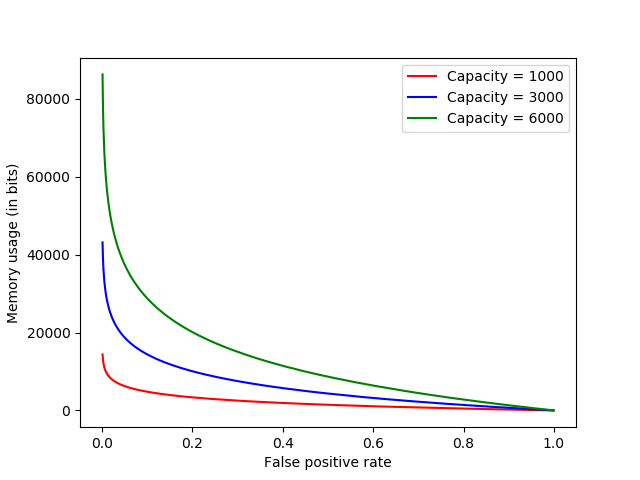

In [5]:
from IPython.display import Image
filename = "plot mem fp.png"
Image(filename)

**2) Memory size scaling as a function of the number of items stored:**

Similar to the previous part, memory, or m, is directly related to the number of items stored, or n, through the function m = -(n x math.log(p)) / ((math.log(2))^2). This time, if p is held constant and n is allowed to change, we see that m is linearly related to n in my implementation.

In my graph, similar to the previous part, we see that a change in p simultaneous to a change in n causes the line to shift up/down by an angle, but the relationship between m and n remains linear.

In [6]:
def plot_mem_cap():
    """Creates a plot of memory usage with regards to capacity. Values for capacity are in an increasing list from 1 to 10000.
        The false positive rate is held at 0.2, 0.4, and 0.6"""
    memory1 = []
    memory2 = []
    memory3 = []

    capacity = [i for i in range(1, 10000)]
    for i in capacity:
        filter1 = bloom(i, 0.2)
        filter2 = bloom(i, 0.4)
        filter3 = bloom(i, 0.6)

        memory1.append(filter1.size)
        memory2.append(filter2.size)
        memory3.append(filter3.size)

    plt.plot(capacity, memory1, color = 'red', label = 'FP rate = 0.2')
    plt.plot(capacity, memory2, color = 'blue', label = 'FP rate = 0.4')
    plt.plot(capacity, memory3, color = 'green', label = 'FP rate = 0.6')
    plt.xlabel('Number of elements stored')
    plt.ylabel('Memory usage (in bits)')
    plt.legend()
    plt.show()

plot_mem_cap()

NameError: name 'bloom' is not defined

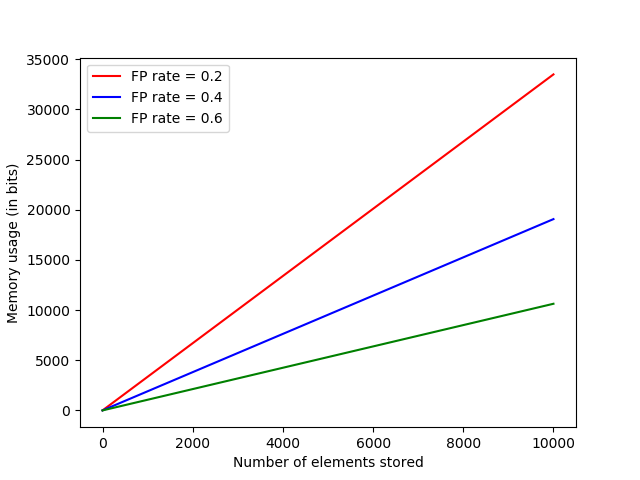

In [7]:
from IPython.display import Image
filename1 = "plot mem cap.png"
Image(filename1)

**3) Access time scaling as a function of the false positive rate:**

Prior to defining what access time is, we need to discuss deeper on how bloom filters are used. Bloom filters are often coupled with other data-storing data structures (lists, arrays, hash tables, hashmaps, ...) in order to support fast querying. Without bloom filters, if we want to query an element in a list or a hash table, the time and space needed to do such querying is subject to the implementation and limitations of these data structures. When these data structures are used with bloom filters, querying now takes two steps: a first check with the bloom filter and a (potential) second check with the data structure.

The **access time** will be defined as the time needed complete these steps, which is constant time for the bloom filter check, plus the potential time it takes to search for an element in the accompanying data structure.

The use of "potential" hints at the usefulness of a bloom filter. If the bloom filter check returns False, then we know for sure that the element does not exist in the underlying data structure and we complete the query with O(1) time. If the bloom filter check returns True, then we check the underlying data structure for the values, and the query time is O(1) + the time it takes to search in that data structure (varies depending on the data structure).

Returning to my implementation of the bloom filter, here is where the false positive rate comes in. In one case, if capacity is held constant and the false positive rate (fp_rate) increases, memory use and the number of hash functions used decrease. This means that the created bloom filter will return false positives more frequently, forcing the user to frequently make unsuccessful queries of the underlying data structure when the user could have just stopped at the O(1) bloom filter check. Following this logic, we can conclude that higher values of p lead to higher **average** access time overall. The inverse is true for lower values of p. How much the access time varies based on the changes in p depends on the type of data structure that the bloom filter is assisting.

**4) Access time scaling as a function of the number of items stored:**

We will continue to use the definition of access time from part 3). With my bloom filter implementation, if the false positive rate is held constant and the number of items stored changes, then the memory usage (size of the bit array) will be adapted in order to maintain the specified false positive rate. If the false positive rate is maintained regardless of how the number of items stored changes, that means my bloom filter will let through a certain number of false positives proportional to the number of items stored everytime.

Because the proportion of bad queries in relation to the number of items stored stays the same with my implementation, the average access time would be the same for a specific underlying data structure as the number of items stored changes.

This average value changes depending on which underlying structure is used and how it handles bad queries. For example, with a simple array, searching is O(n); for a hash table with open addressing, searching is O(1) (but the number of nodes examined differs depending on the type of probing). The use of a hash table would clearly yield a better overall access time than the use of an array.

To conclude, as the number of items stored increases, the access time does not directly scale with the implementation of my bloom filter, but it scales with the time complexity of querying of the underlying data structure.

# 5) Produce a plot to show that your implementation’s false positive rate matches the theoretically expected rate

In [ ]:
def plot_fp():
    """Plotting the actual false positive rate as a function of theoretical false positive rate.
        Capacity of the bloom fitler is held constant at 1000"""
    # Holds the averaged actual false positive rate for each interval of theory_rate
    actual_rate = []

    # The input false positive rate is divided into 200 intervals
    theory_rate = [(1/200)*i for i in range(1, 200)]
    for i in theory_rate:

        # This holds values to be averaged
        result_trial = []
        
        for trial in range(20):  # Run the test 20 times at each i interval to reduce noise
            total_negative = 0  # Total number of negatives
            false_true = 0  # Total number of false positives
            filter = bloom(1000, i)   # Create a bloom filter for the specific i
            data = random.sample(range(100000), 1000)  # This is the data set we will put in the filter
            test = random.sample(range(100000), 1000)  # This is the data used to check the filter     
            
            for x in data:
                filter.insert(x)  # Insert all the data from data
            for y in test:
                if filter.check(y) == False:  # Check every element of test with the bloom filter
                    total_negative += 1  # If False, increment total negatives
                else:
                    if y not in data:  # If True, check to see if the element of y exists in data
                        false_true += 1  # If not, increment total false positives and total negatives
                        total_negative += 1
            fp_rate = false_true/total_negative  # Calculate the false positive rate of THIS trial.
            result_trial.append(fp_rate)

        # Calculate the average result of all trials for THIS i interval
        avg_result = sum(result_trial)/len(result_trial)  
        actual_rate.append(avg_result)  # Append the final result for THIS i interval to actual_rate. 
        
        # Rinse and repeat for other intervals

    plt.plot(theory_rate, actual_rate)
    plt.xlabel('Theoretical false positive rate')
    plt.ylabel('Actual false positive rate')
    plt.show()

plot_fp()

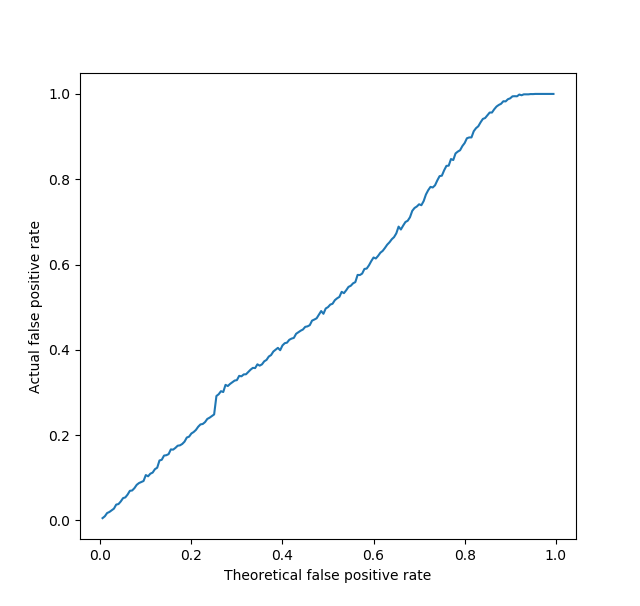

In [1]:
from IPython.display import Image
filename2 = "plot fp2.png"
Image(filename2)

My comments already explained a lot of what is happening in the plot, but I also want to mention other interesting points. First, at each trial, "data" and "test" are randomized, so the total number of negatives would be different each time, which adds to the rigor of the test as the bloom filters (with a specified false positive rate "i") will be tested against a variety of samples. Second, the actual false positive rate of my implementation seems to reach 1 earlier than the theoretical false positive rate imposed by the "bloom" class. This is due to a combination of factors. As explained in my implementation, get_hash() method returns 1 for every input of p > 0.5 because then the theoretical k is between 0 and 1, which is not possible. Also note that an increase in false positive rate input leads to a decrease in memory usage. So, in my graph, for every theoretical false positive rate larger than 0.5, the bloom filters created are being filled up faster than theoretically expected because they are always using 1 hash function, instead of k, where 0 < k < 1, hash function, and memory alloted is decreasing at the same time. Being filled up faster increases the false positive rate, which explains the difference between the theoretical and actual rate at the end of the plot.

# Appendix
- #optimization: My implementation for the bloom filter uses two arguments, the maximum capacity and desired false positive rate, to optimize the number of hash functions used (which affects the running time of insert() and check()) and the amount of memory used (which is the bit array).
- #dataviz: For part 5, I created a function that thoroughly calculates the actual false positive rate and compares it with the theoretical rate. I also explained the nuances in the implementation of the function and in the plot produced.